<a id='top'></a>

# Kolmogorov-Smirnov test

In this notebook we will illustrate the use of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) (K-S test) using functions from the [SciPy stats module](http://docs.scipy.org/doc/scipy/reference/stats.html). In particular, we will look at the influence of the sample size.

## Table of contents

[Preamble](#Preamble)

[Data setup](#Data-setup)

[K-S test](#K-S-test)

[Other tests](#Other-tests)

[Odds and ends](#Odds-and-ends)

## Preamble

The first step is to setup the computational environment. For that we will start by importing the major packages needed for this notebook:

In [2]:
import sys
import math
import numpy as np
import scipy as sp
import matplotlib as mpl
import pandas as pd

Let us check the versions being used:

In [3]:
print('System: {}'.format(sys.version))

for package in (np, sp, mpl, pd):
    print('Package: {} {}'.format(package.__name__, package.__version__))

System: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:27) [GCC 11.2.0]
Package: numpy 1.26.4
Package: scipy 1.13.1
Package: matplotlib 3.10.0
Package: pandas 2.2.3


Now, we import the stats module from the scipy package plus additional modules/packages required by this notebook:

In [4]:
from scipy import stats
import matplotlib.pyplot as plt

To make the plots visible inside the notebook, we need the following Jupyter "magic" command:

In [5]:
%matplotlib inline

Now we are ready to start exploring.

[Back to top](#top)

## Data setup

First of all, we will define a normal random variable (RV) with mean 1.0 and standard deviation 0.1:

In [6]:
mean = 1.0
std = 0.1
rv = stats.norm(loc=mean, scale=std)

This is said to be a 'frozen' RV object since the location and scale parameters are given. Let us plot the probability density function (pdf) as well as the cumulative density function (cdf), between percentiles 0.001 and 0.999, to check the random variable:

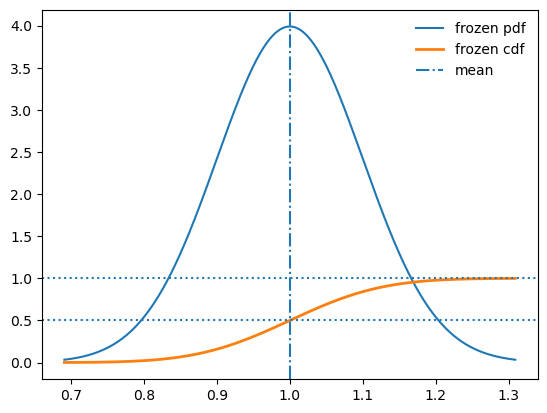

In [7]:
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), label='frozen pdf')
ax.plot(x, rv.cdf(x), lw=2, label='frozen cdf')
ax.axhline(0.5, ls=':')
ax.axhline(1.0, ls=':')
ax.axvline(mean, ls='-.', label='mean')
ax.legend(loc='best', frameon=False)
plt.show()

Now we will generate nine random samples, ranging from 10 to 5000 samples, and look at them in a histogram plot together with the normal pdf to see how they match:

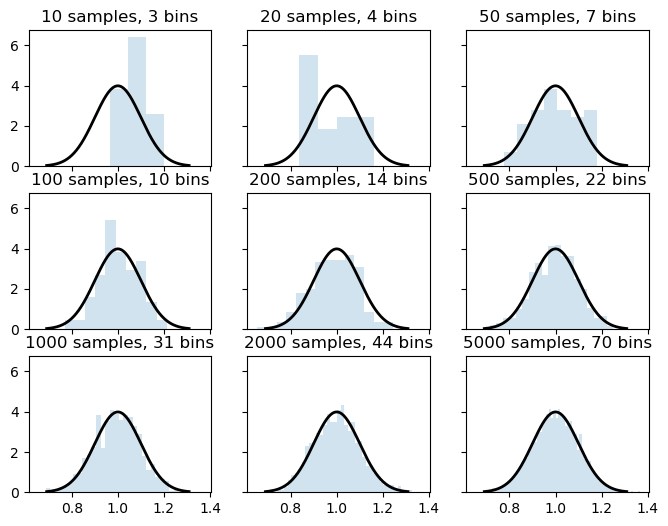

In [8]:
Nsamples = [u*d for d in (10,100,1000) for u in (1,2,5)]
ysamples = []
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,6))

for row in range(3):

    for col in range(3):
        N = Nsamples[3*row+col]
        ax[row,col].plot(x, rv.pdf(x), 'k-', lw=2)
        y = rv.rvs(size=N)
        b = int(math.sqrt(N))
        ysamples.append(y)
        ax[row,col].hist(y, bins=b, density=True, histtype='stepfilled', alpha=0.2)
        ax[row,col].set_title('{} samples, {} bins'.format(N, b))

plt.show()

We used a different number of bins in the histogram plots in order to increase the discretization. As can be seen, the larger the size of the random sample, the better it fits the normal pdf. Similarly, we can plot the random samples, after ordering them in ascending order (empirical cumulative distribution function), together with the normal cdf:

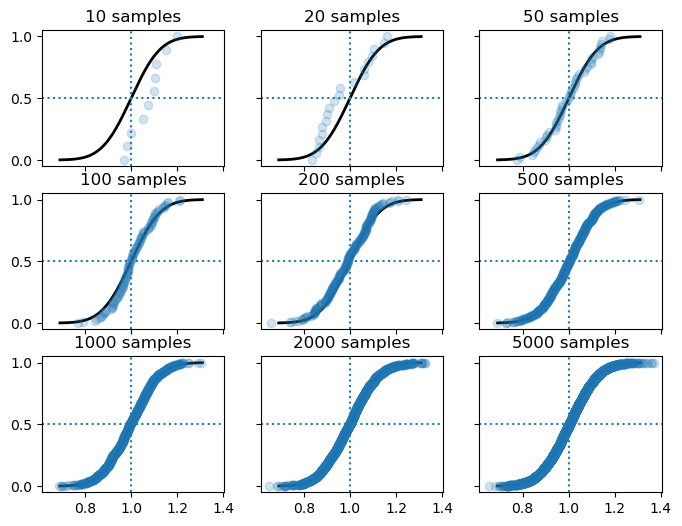

In [9]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,6))

for row in range(3):

    for col in range(3):
        N = Nsamples[3*row+col]
        y = ysamples[3*row+col]
        ax[row,col].plot(x, rv.cdf(x), 'k-', lw=2)
        yn = np.sort(y)
        xn = np.linspace(0., 1., num=N)
        ax[row,col].plot(yn, xn, 'o', alpha=0.2)
        ax[row,col].axhline(0.5, ls=':')
        ax[row,col].axvline(mean, ls=':')
        ax[row,col].set_title('{} samples'.format(N))

plt.show()

Interestingly, the larger the sample size the better it fits the normal cdf. But then again, this is what can be expected after seeing the histogram plots.

## K-S test

Finally, let us compute the K-S test for goodness of fit:

In [10]:
Dsamples = []
psamples = []

for N,y in zip(Nsamples, ysamples):
    D, pvalue = stats.kstest(y, 'norm', args=(mean, std))
    Dsamples.append(D)
    psamples.append(pvalue)
    print('{:4d} samples: D={}, pvalue={}'.format(N, D, pvalue))

  10 samples: D=0.39947886800517624, pvalue=0.05953354954980694
  20 samples: D=0.2698448094794725, pvalue=0.08910807008132371
  50 samples: D=0.07122959434861725, pvalue=0.9458137672815953
 100 samples: D=0.0856617775560834, pvalue=0.43133909954886906
 200 samples: D=0.0689689875704661, pvalue=0.28413836123202574
 500 samples: D=0.02303603694287959, pvalue=0.9478620990762164
1000 samples: D=0.03336679635936579, pvalue=0.2107646872939548
2000 samples: D=0.02846488552528345, pvalue=0.07675692460215766
5000 samples: D=0.011353141962258784, pvalue=0.5358138617227984


Let us plot these results to see that they are pretty much scattered:

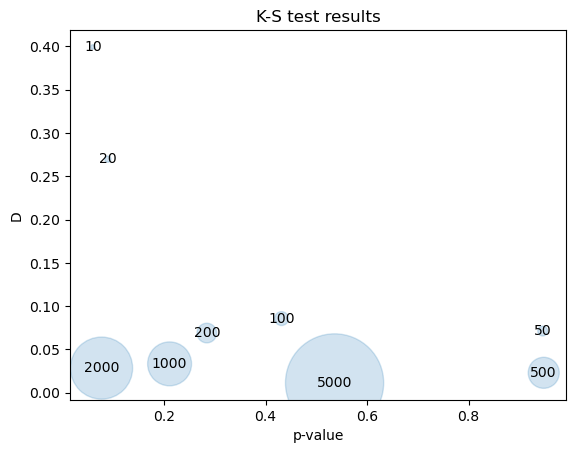

In [11]:
fig, ax = plt.subplots(1, 1)
ax.scatter(psamples, Dsamples, s=Nsamples, alpha=0.2)

for p,D,N in zip(psamples, Dsamples, Nsamples):
    ax.text(p, D, str(N), ha='center', va='center')

ax.set_xlabel('p-value')
ax.set_ylabel('D')
ax.set_title('K-S test results')
plt.show()

It is curious to see that the highest p-value does not occur for the lowest K-S statistic (D) value. In fact, it seems that, as the size of the sample increases, the p-value does not show a tendency to increase, despite the fact that both the histogram plot and the ordered sample plot seem to fit better the normal pdf and cdf, respectively.

## Other tests

For comparison, we will perform two other tests. First, the [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) (A-D test), for data coming from a particular distribution:

In [12]:
for N,y in zip(Nsamples, ysamples):
    A2, critical_values, significance_level = stats.anderson(y)
    print('{:4d} samples: A2={}'.format(N, A2), critical_values, significance_level)

  10 samples: A2=0.2266245761572918 [0.501 0.57  0.684 0.798 0.95 ] [15.  10.   5.   2.5  1. ]
  20 samples: A2=0.7854918079687785 [0.506 0.577 0.692 0.807 0.96 ] [15.  10.   5.   2.5  1. ]
  50 samples: A2=0.2505712577984909 [0.538 0.613 0.736 0.858 1.021] [15.  10.   5.   2.5  1. ]
 100 samples: A2=0.24548134338434124 [0.555 0.632 0.759 0.885 1.053] [15.  10.   5.   2.5  1. ]
 200 samples: A2=0.6857952072315356 [0.565 0.644 0.772 0.901 1.071] [15.  10.   5.   2.5  1. ]
 500 samples: A2=0.31990905572121164 [0.571 0.651 0.781 0.911 1.083] [15.  10.   5.   2.5  1. ]
1000 samples: A2=0.40406869607227236 [0.574 0.653 0.784 0.914 1.088] [15.  10.   5.   2.5  1. ]
2000 samples: A2=0.43554156477466677 [0.575 0.655 0.785 0.916 1.09 ] [15.  10.   5.   2.5  1. ]
5000 samples: A2=0.17618005234544398 [0.576 0.655 0.786 0.917 1.091] [15.  10.   5.   2.5  1. ]


Second, since we are using a normal random variable, the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) (S-W test) for normality:

In [13]:
Wsamples = []
psamples = []

for N,y in zip(Nsamples, ysamples):
    W, pvalue = stats.shapiro(y)
    Wsamples.append(W)
    psamples.append(pvalue)
    print('{:4d} samples: W={}, pvalue={}'.format(N, W, pvalue))

  10 samples: W=0.9585259422864343, pvalue=0.7689421884719673
  20 samples: W=0.8990676095292399, pvalue=0.03961320584562708
  50 samples: W=0.9792237717180508, pvalue=0.5197077273071131
 100 samples: W=0.9934083652570815, pvalue=0.9114298199232869
 200 samples: W=0.9901575784091828, pvalue=0.18838984477400378
 500 samples: W=0.9975343442406366, pvalue=0.6734889566761881
1000 samples: W=0.9984643295132167, pvalue=0.531556126271145
2000 samples: W=0.998614495416363, pvalue=0.10323200631548196
5000 samples: W=0.9997118475449576, pvalue=0.7419557058417254


It is not easy to plot the A-D test results, but the S-W test results are:

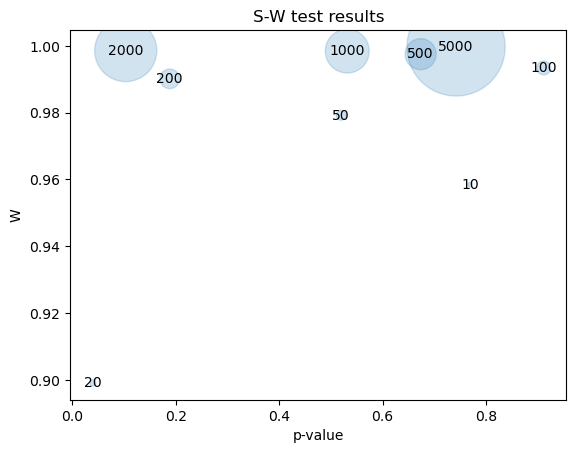

In [14]:
fig, ax = plt.subplots(1, 1)
ax.scatter(psamples, Wsamples, s=Nsamples, alpha=0.2)

for p,W,N in zip(psamples, Wsamples, Nsamples):
    ax.text(p, W, str(N), ha='center', va='center')

ax.set_xlabel('p-value')
ax.set_ylabel('W')
ax.set_title('S-W test results')
plt.show()

Both tests show that ... (to be concluded!).

[Back to top](#top)

## Odds and ends

This notebook was created by Paulo Xavier Candeias.

[Back to top](#top)